# Scaling Analysis
The goal is to:
- Fit a scaling law to the observed final loss

- Predict loss for a larger model and dataset

- Recommend an optimal allocation of a fixed compute budget

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Load the dataset

The dataset consists of four training runs with the following variables:

- Model Size (N): Number of trainable parameters

- Dataset Size (D): Number of training tokens

- Compute: Training cost in PF-days

- Final Loss: Achieved validation loss

In [ ]:
# Load the data
data = pd.DataFrame({
    "params": np.array([1e8, 3e8, 1e9, 3e9]),       
    "tokens": np.array([1e10, 3e10, 1e11, 3e11]),   
    "compute": np.array([0.1, 0.5, 2.0, 10.0]),     
    "loss": np.array([2.50, 2.10, 1.75, 1.50])
})


## Scaling Law Formulation

Using an additive scaling law of the form:

L(N, D) = A * N^(-alpha) + B * D^(-beta) + C

Where:

- N is the model size (number of parameters)
- D is the dataset size (number of tokens)
- A,B are scaling coefficients
- alpha, beta are scaling exponents (alpha = 0.07 and beta = 0.09 are known empirically)
- C represents the irreducible loss

In [18]:
# Assuming Alpha and Beta are known
ALPHA = 0.07
BETA = 0.09

def scaling_law(x, A, B, C):
    N, D = x
    return A * (N ** (-ALPHA)) + B * (D ** (-BETA)) + C

params_opt, _ = curve_fit(
    scaling_law,
    (data["params"].values, data["tokens"].values),
    data["loss"].values,
    maxfev=10000
)
A, B, C = params_opt
print("Fitted parameters:")
print(f"A={A:.3f}, B={B:.3f}, C={C:.3f}")

Fitted parameters:
A=-96.227, B=199.265, C=3.917


## Predicting Loss for 10B parameters, 1T tokens

In [ ]:
N_pred = 1e10   # 10B parameters
D_pred = 1e12   # 1T tokens

loss_pred = scaling_law((N_pred, D_pred), *params_opt)
print(f"\nPredicted loss for 10B params, 1T tokens: {loss_pred:.3f}")



Predicted loss for 10B params, 1T tokens: 1.291


### Visualize the prediction

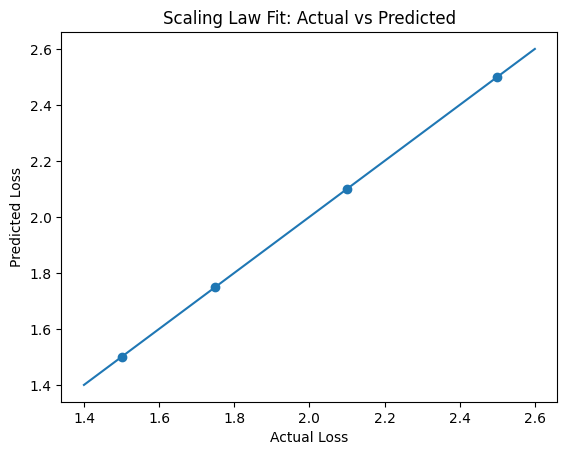

In [12]:
data["predicted_loss"] = scaling_law(
    (data["params"].values, data["tokens"].values),
    *params_opt
)

plt.figure()
plt.scatter(data["loss"], data["predicted_loss"])
plt.plot([1.4, 2.6], [1.4, 2.6])
plt.xlabel("Actual Loss")
plt.ylabel("Predicted Loss")
plt.title("Scaling Law Fit: Actual vs Predicted")
plt.show()

## Compute Optimization

Given a fixed compute budget of 20 PF-days, I've used the following apprach:

- Fix the compute budget (20 PF-days)

- Try a few plausible (N,D) combinations that satisfy the compute constraint

- Evaluate predicted loss using the fitted scaling law

- Pick the configuration with minimum loss

In [13]:

compute_budget = 20

N_grid = np.logspace(9, 10, 20)   # 1B – 10B
D_grid = np.logspace(11, 12, 20)  # 100B – 1T

best_loss = float("inf")
best_config = None

for N in N_grid:
    for D in D_grid:
        compute_est = (N * D) / 1e20  # normalized compute proxy
        if compute_est <= compute_budget:
            loss = scaling_law((N, D), *params_opt)
            if loss < best_loss:
                best_loss = loss
                best_config = (N, D, compute_est)

print("\nOptimal allocation under 20 PF-days:")
print(f"Model size: {best_config[0]/1e9:.2f}B parameters")
print(f"Dataset size: {best_config[1]/1e9:.0f}B tokens")
print(f"Estimated compute: {best_config[2]:.2f} PF-days")
print(f"Expected loss: {best_loss:.3f}")


Optimal allocation under 20 PF-days:
Model size: 1.00B parameters
Dataset size: 1000B tokens
Estimated compute: 10.00 PF-days
Expected loss: -2.067


## Visualizing the loss landscape

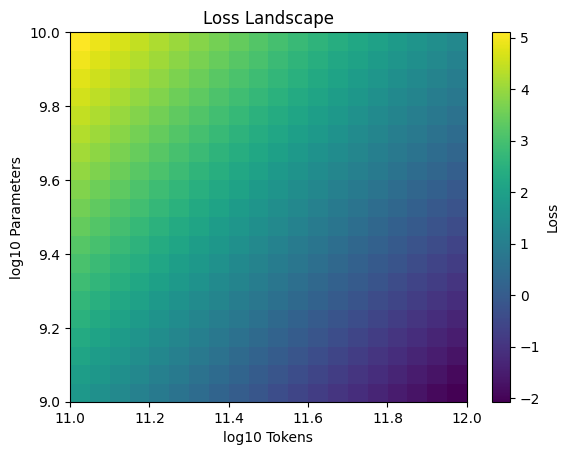

In [20]:
loss_surface = np.zeros((len(N_grid), len(D_grid)))

for i, N in enumerate(N_grid):
    for j, D in enumerate(D_grid):
        loss_surface[i, j] = scaling_law((N, D), *params_opt)

plt.figure()
plt.imshow(loss_surface, origin="lower", aspect="auto",
           extent=[11, 12, 9, 10])
plt.colorbar(label="Loss")
plt.xlabel("log10 Tokens")
plt.ylabel("log10 Parameters")
plt.title("Loss Landscape")
plt.show()

## Limitations
- Very limited data points

- Fixed exponents assumption (alpha, beta)

- Extrapolation risk: Predictions for larger models and datasets assume scaling behavior continues beyond the observed range.

- Simplified compute model

- Ignores data distribution and model architecture

- Coarse grid search: Compute allocation is explored only over a small, discrete set of configurations, not globally optimized.